In [1]:
"""
Multiple Correspondence Analysis (MCA) - Obesity Dataset
Approach 1: Transform quantitative variables to categorical

This notebook performs MCA on categorical variables including discretized
quantitative variables (Age and Weight).
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("Set2")

In [2]:
# Load data
df = pd.read_csv("dataset/obesity.csv")

# Select variables
categorical_vars = [
    "Gender",
    "family_history_with_overweight",
    "FAVC",
    "CAEC",
    "MTRANS",
]

quantitative_vars = ["Age", "Weight"]
target_var = "NObeyesdad"

# Extract subset
df_subset = df[categorical_vars + quantitative_vars + [target_var]].copy()

print(f"Dataset: {len(df_subset)} observations")
print(
    f"Variables: {len(categorical_vars)} categorical + {len(quantitative_vars)} quantitative"
)

Dataset: 2111 observations
Variables: 5 categorical + 2 quantitative


In [3]:
# Descriptive statistics
print("\nCategorical variables:")
for var in categorical_vars:
    print(f"\n{var}:")
    counts = df_subset[var].value_counts()
    for category, count in counts.items():
        print(f"  {category}: {count} ({count/len(df_subset)*100:.1f}%)")

print("\nQuantitative variables:")
print(df_subset[quantitative_vars].describe().round(2))


Categorical variables:

Gender:
  Male: 1068 (50.6%)
  Female: 1043 (49.4%)

family_history_with_overweight:
  yes: 1726 (81.8%)
  no: 385 (18.2%)

FAVC:
  yes: 1866 (88.4%)
  no: 245 (11.6%)

CAEC:
  Sometimes: 1765 (83.6%)
  Frequently: 242 (11.5%)
  Always: 53 (2.5%)
  no: 51 (2.4%)

MTRANS:
  Public_Transportation: 1580 (74.8%)
  Automobile: 457 (21.6%)
  Walking: 56 (2.7%)
  Motorbike: 11 (0.5%)
  Bike: 7 (0.3%)

Quantitative variables:
           Age   Weight
count  2111.00  2111.00
mean     24.31    86.59
std       6.35    26.19
min      14.00    39.00
25%      19.95    65.47
50%      22.78    83.00
75%      26.00   107.43
max      61.00   173.00


In [4]:
# Transform quantitative to categorical
df_categorical = df_subset[categorical_vars].copy()

# Age: 3 groups
age_bins = [0, 25, 40, 100]
age_labels = ["Young (≤25)", "Adult (26-40)", "Senior (>40)"]
df_categorical["Age_Cat"] = pd.cut(
    df_subset["Age"], bins=age_bins, labels=age_labels, include_lowest=True
)

# Weight: 3 groups
weight_bins = [0, 65, 85, 200]
weight_labels = ["Light (<65kg)", "Medium (65-85kg)", "Heavy (>85kg)"]
df_categorical["Weight_Cat"] = pd.cut(
    df_subset["Weight"], bins=weight_bins, labels=weight_labels, include_lowest=True
)

print("\nCategorical transformation:")
print(f"Age groups:\n{df_categorical['Age_Cat'].value_counts().sort_index()}")
print(f"\nWeight groups:\n{df_categorical['Weight_Cat'].value_counts().sort_index()}")


Categorical transformation:
Age groups:
Age_Cat
Young (≤25)      1369
Adult (26-40)     685
Senior (>40)       57
Name: count, dtype: int64

Weight groups:
Weight_Cat
Light (<65kg)       520
Medium (65-85kg)    608
Heavy (>85kg)       983
Name: count, dtype: int64


In [5]:
# Create indicator matrix
df_indicators = pd.get_dummies(df_categorical, drop_first=False, dtype=int)
print(
    f"\nIndicator matrix: {df_indicators.shape[0]} rows × {df_indicators.shape[1]} columns"
)

# Standardize indicator matrix
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_indicators)

# Apply MCA (PCA on indicator matrix)
n_components = 10
mca = PCA(n_components=n_components)
X_mca = mca.fit_transform(X_scaled)

# Variance explained
print("\nVariance explained:")
cumulative = 0
for i, var in enumerate(mca.explained_variance_ratio_[:5], 1):
    cumulative += var
    print(f"Dimension {i}: {var*100:.2f}% (cumulative: {cumulative*100:.2f}%)")


Indicator matrix: 2111 rows × 21 columns

Variance explained:
Dimension 1: 20.33% (cumulative: 20.33%)
Dimension 2: 12.18% (cumulative: 32.51%)
Dimension 3: 9.70% (cumulative: 42.21%)
Dimension 4: 8.42% (cumulative: 50.63%)
Dimension 5: 7.56% (cumulative: 58.19%)


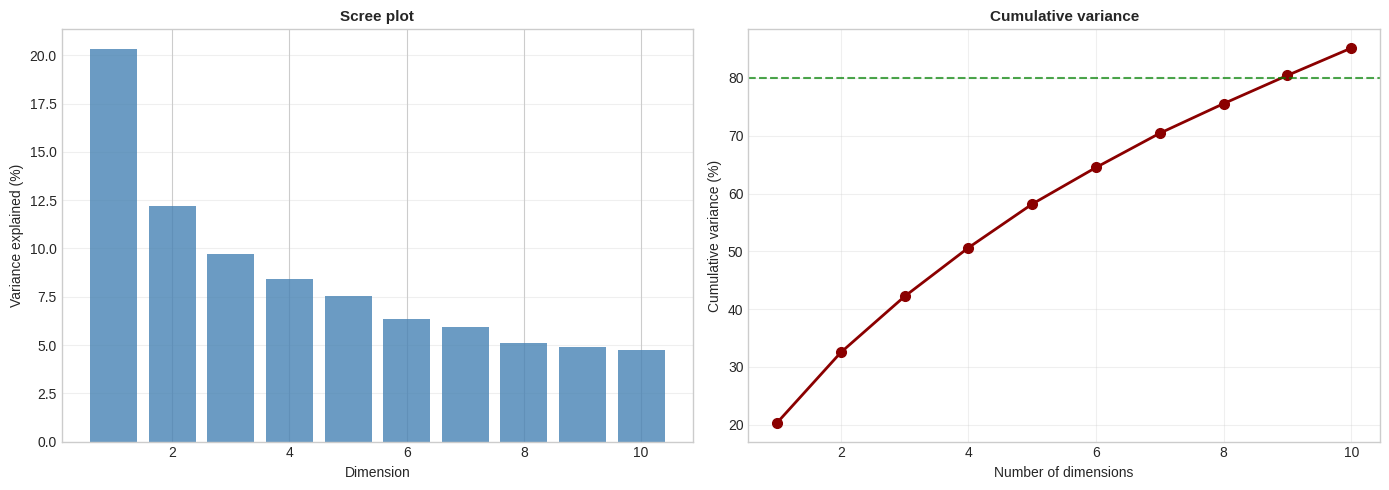

In [6]:
# Scree plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.bar(
    range(1, n_components + 1),
    mca.explained_variance_ratio_ * 100,
    color="steelblue",
    alpha=0.8,
)
ax1.set_xlabel("Dimension", fontsize=10)
ax1.set_ylabel("Variance explained (%)", fontsize=10)
ax1.set_title("Scree plot", fontsize=11, fontweight="bold")
ax1.grid(axis="y", alpha=0.3)

cumulative = np.cumsum(mca.explained_variance_ratio_ * 100)
ax2.plot(
    range(1, n_components + 1),
    cumulative,
    marker="o",
    linewidth=2,
    markersize=7,
    color="darkred",
)
ax2.axhline(y=80, color="green", linestyle="--", linewidth=1.5, alpha=0.7)
ax2.set_xlabel("Number of dimensions", fontsize=10)
ax2.set_ylabel("Cumulative variance (%)", fontsize=10)
ax2.set_title("Cumulative variance", fontsize=11, fontweight="bold")
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("approach1_scree.png", dpi=300, bbox_inches="tight")
plt.show()

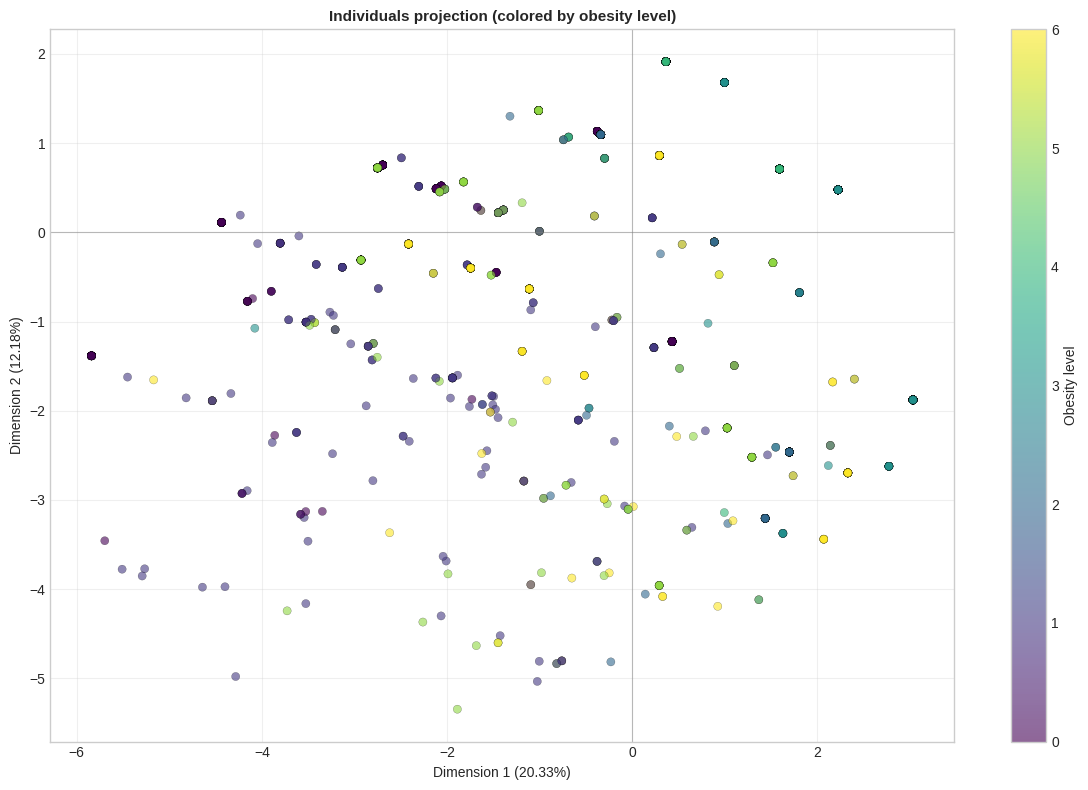

In [7]:
# Individuals projection
fig, ax = plt.subplots(figsize=(12, 8))

obesity_codes = pd.Categorical(df_subset[target_var]).codes
scatter = ax.scatter(
    X_mca[:, 0],
    X_mca[:, 1],
    c=obesity_codes,
    cmap="viridis",
    alpha=0.6,
    s=35,
    edgecolors="k",
    linewidth=0.2,
)

ax.axhline(y=0, color="gray", linewidth=0.8, alpha=0.5)
ax.axvline(x=0, color="gray", linewidth=0.8, alpha=0.5)
ax.set_xlabel(f"Dimension 1 ({mca.explained_variance_ratio_[0]*100:.2f}%)", fontsize=10)
ax.set_ylabel(f"Dimension 2 ({mca.explained_variance_ratio_[1]*100:.2f}%)", fontsize=10)
ax.set_title(
    "Individuals projection (colored by obesity level)", fontsize=11, fontweight="bold"
)
ax.grid(alpha=0.3)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("Obesity level", fontsize=10)

plt.tight_layout()
plt.savefig("approach1_individuals.png", dpi=300, bbox_inches="tight")
plt.show()

In [8]:
# Variable categories contributions
loadings = mca.components_.T
contributions_df = pd.DataFrame(
    loadings[:, :3], columns=["Dim1", "Dim2", "Dim3"], index=df_indicators.columns
)

print("\nTop 10 contributors to Dimension 1:")
for cat, contrib in (
    contributions_df["Dim1"].abs().sort_values(ascending=False).head(10).items()
):
    print(f"  {cat}: {contrib:.3f}")

print("\nTop 10 contributors to Dimension 2:")
for cat, contrib in (
    contributions_df["Dim2"].abs().sort_values(ascending=False).head(10).items()
):
    print(f"  {cat}: {contrib:.3f}")


Top 10 contributors to Dimension 1:
  family_history_with_overweight_yes: 0.336
  family_history_with_overweight_no: 0.336
  Weight_Cat_Light (<65kg): 0.323
  Weight_Cat_Heavy (>85kg): 0.312
  CAEC_Sometimes: 0.307
  Age_Cat_Young (≤25): 0.297
  Age_Cat_Adult (26-40): 0.283
  CAEC_Frequently: 0.273
  FAVC_no: 0.225
  FAVC_yes: 0.225

Top 10 contributors to Dimension 2:
  MTRANS_Public_Transportation: 0.525
  MTRANS_Automobile: 0.472
  Age_Cat_Young (≤25): 0.317
  Age_Cat_Adult (26-40): 0.252
  FAVC_no: 0.240
  FAVC_yes: 0.240
  Weight_Cat_Heavy (>85kg): 0.210
  Age_Cat_Senior (>40): 0.208
  Weight_Cat_Medium (65-85kg): 0.179
  MTRANS_Walking: 0.152


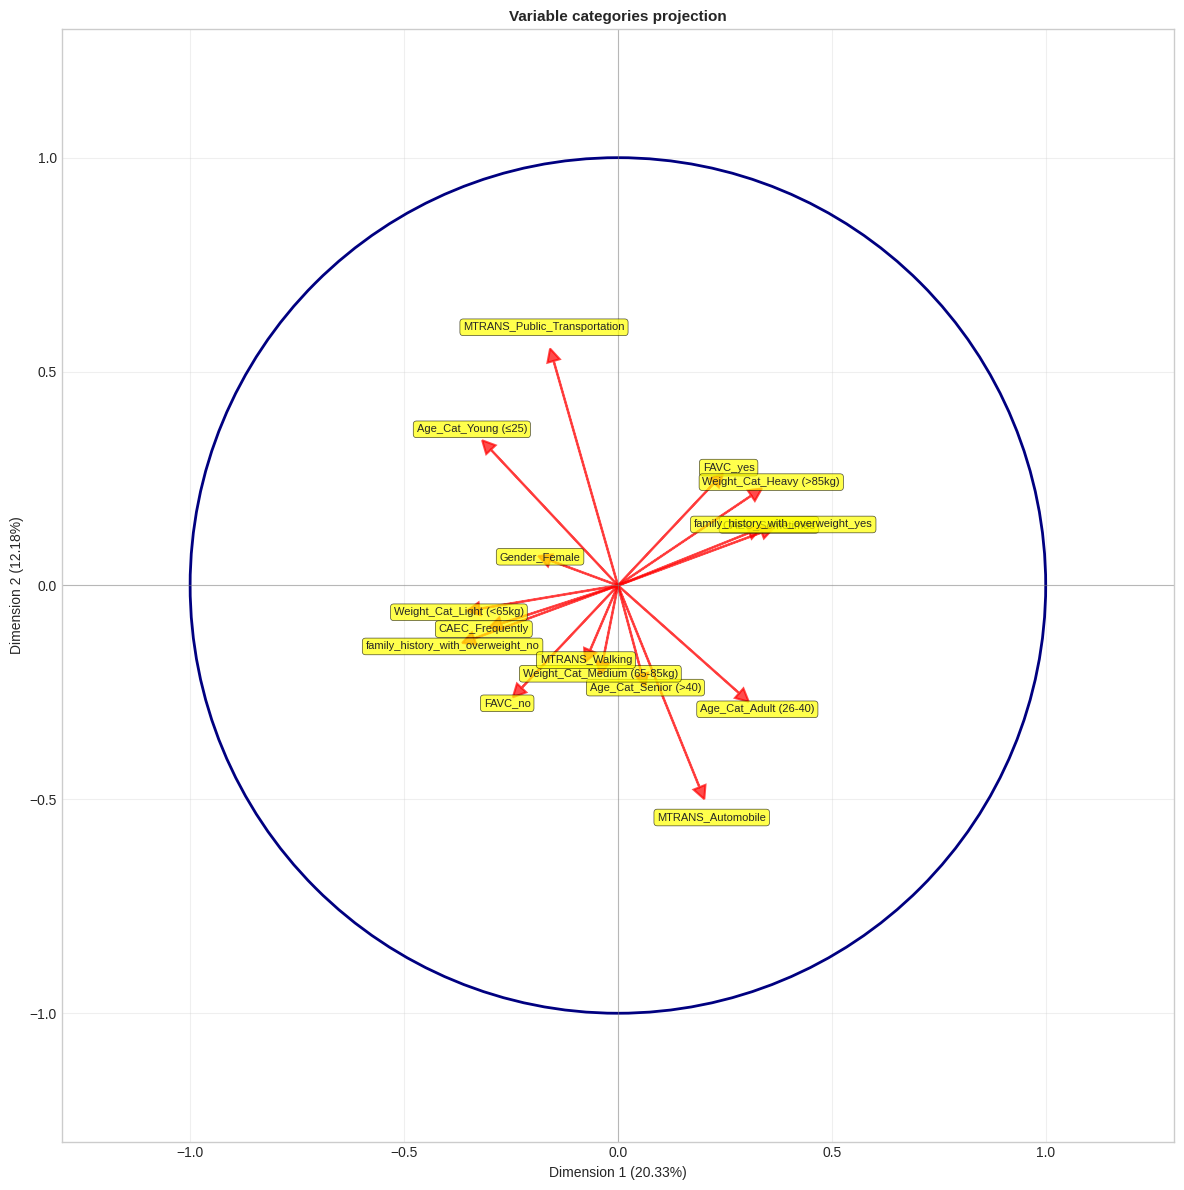

In [9]:
# Categories projection
fig, ax = plt.subplots(figsize=(12, 12))

circle = plt.Circle((0, 0), 1, color="navy", fill=False, linewidth=2)
ax.add_patch(circle)

# Select top categories for display
top_categories = set(
    list(contributions_df["Dim1"].abs().nlargest(12).index)
    + list(contributions_df["Dim2"].abs().nlargest(12).index)
)

for category in top_categories:
    x = contributions_df.loc[category, "Dim1"]
    y = contributions_df.loc[category, "Dim2"]

    ax.arrow(
        0,
        0,
        x,
        y,
        head_width=0.03,
        head_length=0.03,
        fc="red",
        ec="red",
        linewidth=1.5,
        alpha=0.7,
    )

    ax.text(
        x * 1.15,
        y * 1.15,
        category,
        fontsize=8,
        ha="center",
        va="center",
        bbox=dict(
            boxstyle="round,pad=0.3",
            facecolor="yellow",
            alpha=0.7,
            edgecolor="black",
            linewidth=0.5,
        ),
    )

ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-1.3, 1.3)
ax.axhline(y=0, color="gray", linewidth=0.8, alpha=0.5)
ax.axvline(x=0, color="gray", linewidth=0.8, alpha=0.5)
ax.set_xlabel(f"Dimension 1 ({mca.explained_variance_ratio_[0]*100:.2f}%)", fontsize=10)
ax.set_ylabel(f"Dimension 2 ({mca.explained_variance_ratio_[1]*100:.2f}%)", fontsize=10)
ax.set_title("Variable categories projection", fontsize=11, fontweight="bold")
ax.grid(alpha=0.3)
ax.set_aspect("equal")

plt.tight_layout()
plt.savefig("approach1_categories.png", dpi=300, bbox_inches="tight")
plt.show()

In [10]:
# Summary
print("\nSummary:")
print(
    f"  Total variance (first 2 dims): {mca.explained_variance_ratio_[:2].sum()*100:.2f}%"
)
print(
    f"  Total variance (first 3 dims): {mca.explained_variance_ratio_[:3].sum()*100:.2f}%"
)
print(f"  Active variables: {len(df_categorical.columns)}")
print(f"  Indicator variables: {len(df_indicators.columns)}")


Summary:
  Total variance (first 2 dims): 32.51%
  Total variance (first 3 dims): 42.21%
  Active variables: 7
  Indicator variables: 21
